# EEG Cannabis Sleep Consulting Project

## Methods Daft

This notebook contains the functions we used and brief descriptions of what they do and how we used them in our implementation.

### Section 1: Library & Data Loading

The dataset consists of two main file types, an edf trace file consisting of electrophysiology, and a rml containing metadata such as technician notes. Standard python libraries are used for data loading, visualization, and manipulation. Speciailized functions from the MNE library allow for reading and manipulation of the edf data. The main pages for these functions can be found here: 
https://docs.python.org/3/library/os.html
https://mne.tools/stable/index.html

In [1]:
# Library Loading
import mne, os
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

/home/sam/anaconda3/envs/EEG/lib/python3.9/site-packages/numba/core/errors.py:194: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


The next cell sets up file path interogation using the os package. The file path leads to an edf file, which contains the signal data we want to read in as well as the rml containing important meta data. The os package is used to allow for greater flexibility and ultimately operating system agnosticism. 
Documentation: https://docs.python.org/3/library/os.path.html#module-os.path

In [2]:
data_root = os.path.join(os.getcwd(), 'Examples2024', '00000016-APDx20974') # this is an example participant ID
data_path = os.path.join(data_root, '00000016-APDx20974[001].edf')
meta_path = os.path.join(data_root, '00000016-APDx20974.rml')

#### Section 1.1: Metadata Loading

Metadata associated with each recording is stored as .xml files. To interogate these in python the following functions were devised to convert a given .xml into a dictionary for native handling in python.

In [3]:
def get_namespaces(file_path):
    """
    Parses the XML file and extracts namespaces as a dictionary.
    Namespaces in XML are declared in the root element or throughout the document.
    
    Args:
    - file_path: Path to the XML file.
    
    Returns:
    A dictionary with namespace prefixes as keys and URIs as values.
    """
    namespaces = {}
    for event, elem in ET.iterparse(file_path, events=('start-ns',)):
        prefix, uri = elem
        namespaces[prefix] = uri
    return namespaces

def xml_to_dict(element, namespaces):
    """
    Recursively convert an XML element and its children into a dictionary.
    
    Args:
    - element: The XML element to convert.
    - namespaces: A dictionary of XML namespaces.
    
    Returns:
    A dictionary representation of the XML element.
    """
    # Base case: If the element has no children, return its text content
    # or an empty string if the content is None.
    if not list(element):  # Checks if the element has no children
        return element.text or ''
    
    # Recursion: Convert children into dictionary entries
    element_dict = {}
    for child in element:
        child_tag = child.tag.split('}')[-1]  # Removes the namespace URI if present
        child_dict = xml_to_dict(child, namespaces)  # Recursive call
        
        # Handle cases where tags are repeated by aggregating them into lists
        if child_tag in element_dict:
            if not isinstance(element_dict[child_tag], list):
                # Convert existing entry into a list
                element_dict[child_tag] = [element_dict[child_tag]]
            element_dict[child_tag].append(child_dict)
        else:
            element_dict[child_tag] = child_dict
    
    return element_dict

def convert_rml_to_dict(metadata_path):
    """
    Reads a .rml file, parses it, and converts it into a dictionary.
    
    Args:
    - metadata_path: Path to the .rml file.
    
    Returns:
    A dictionary representing the .rml file's structure.
    """
    # Read and parse the .rml file
    tree = ET.parse(metadata_path)
    root = tree.getroot()

    # Generate namespaces dictionary automatically
    namespaces = get_namespaces(metadata_path)

    # Convert the root XML element to a dictionary
    return xml_to_dict(root, namespaces)

Example loading of an xml as a dictionary, and example useage of pythonic key-value interogation to extract important metadata related to estimating sleep onset time are displayed in the following cell.

In [4]:
# Example Loading
xml_dict = convert_rml_to_dict(meta_path)
print(f'MetaData Keys: {xml_dict.keys()}')

# Example MetaData Extraction Via key-value assignment where values can be subdictionaries
clock_t0 = xml_dict['Acquisition']['Sessions']['Session']['RecordingStart']
t_lightOFF = xml_dict['Acquisition']['Sessions']['Session']['LightsOff']
t_lightON = xml_dict['Acquisition']['Sessions']['Session']['LightsOn']
sex = xml_dict['Patient']['Gender']
print(f'\nRecording began at {clock_t0}, lights OFF at: {t_lightOFF} seconds, lights ON at: {t_lightON} seconds, wiht a {sex} patient')

MetaData Keys: dict_keys(['Patient', 'ChannelConfig', 'Acquisition', 'CustomEventTypeDefs', 'AcquisitionCommentDefs', 'ScoringData', 'AnalysisOptions', 'ReportCalcOptions', 'EventFilters', 'TrendChannelMappings'])

Recording began at 2016-09-15T19:25:47, lights OFF at: 13350 seconds, lights ON at: 41112 seconds, wiht a Male patient


#### Section 1.2: E-Phys Loading
The next cell loads the edf file of our choice (based on previous block), loads it into 'raw', and then prints information about it. We then select the channels we want to be able to plot/get information about. The channels we choose are loaded into 'selected_channels'. 
The package that lets us do this is the mne python package. The documentation can be seen here: 
https://mne.tools/stable/generated/mne.io.read_raw_edf.html
https://mne.tools/stable/generated/mne.Info.html

Sample channel loading and isolation implementation: 

In [5]:
# Load an EDF file
raw = mne.io.read_raw_edf(data_path, preload=True) # data path is the file's location

# Print information about the file
print(raw.info)

# Print all channel names to review them
print(raw.info['ch_names'])
# the channel names tell us which signals we are looking at

# Subset to only EEG Channels and print general data
selected_channels = raw.pick(['EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1', 'EEG A1-A2', 'EMG Chin', 'EMG Aux1'])

display(selected_channels)

Extracting EDF parameters from /home/sam/Classes/Stats/Consulting/EEG_Consulting/Examples2024/00000016-APDx20974/00000016-APDx20974[001].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9235599  =      0.000 ... 46177.995 secs...


/tmp/ipykernel_2374784/3144834223.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'Flow Patient'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(data_path, preload=True) # data path is the file's location


<Info | 8 non-empty values
 bads: []
 ch_names: EEG C3-A2, EEG C4-A1, EEG O1-A2, EEG O2-A1, EMG Chin, EMG Aux1, ...
 chs: 17 EEG
 custom_ref_applied: False
 highpass: 0.3 Hz
 lowpass: 35.0 Hz
 meas_date: 2016-09-15 19:25:47 UTC
 nchan: 17
 projs: []
 sfreq: 200.0 Hz
 subject_info: 3 items (dict)
>
['EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1', 'EMG Chin', 'EMG Aux1', 'ECG V', 'Flow Patient-0', 'Flow Patient-1', 'Effort THO', 'Effort ABD', 'SpO2', 'Pleth', 'PulseRate', 'EEG A1-A2', 'PPG', 'Technical']


Measurement date,"September 15, 2016 19:25:47 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,7 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.30 Hz
Lowpass,35.00 Hz


Output: 

### Section 2: Data Cleaning
Before analysis, the dataset must be first assessed for gross unuseability, and next subset to the time periods of interest.

#### Section 2.1: Evaluation of Technician Notes
Exploring the meta-data one will find comments and channel failure events. These can be assessed in one of two ways as demonstrated below. First, an automateable extraction of the comments into a list is performed. These results can be printed as demonstrated and a human expert can decide if the technician noted a signifigant technical failure. 

In [6]:
def extract_relevant_annotations(scoring_data):
    # Initialize containers for different types of annotations
    channel_fail_events = []
    comments_with_timestamps = {}
    
    # Check if 'Events' key exists in 'ScoringData'
    if 'Events' in scoring_data and 'Event' in scoring_data['Events']:
        for event in scoring_data['Events']['Event']:
            # Extract ChannelFail events
            if 'ChannelFail' in event and event['ChannelFail']:
                channel_fail_events.append(event['ChannelFail'])
            
            # Extract other comments, like 'Comment' or specific conditions
            # Assume 'timestamp' is the key where the timestamp is stored in each event
            if 'Comment' in event and event['Comment']:
                comment = event['Comment']
                timestamp = event.get('timestamp', 'unknown')  # Provide a default value in case timestamp is missing
                
                # Check if this comment has already been recorded
                if comment in comments_with_timestamps:
                    # Append the new timestamp to the existing list for this comment
                    comments_with_timestamps[comment].append(timestamp)
                else:
                    # Otherwise, start a new list with this timestamp
                    comments_with_timestamps[comment] = [timestamp]
    
    return channel_fail_events, comments_with_timestamps

# Try to see commentary in the file
scoring_data = xml_dict.get('ScoringData', {})
channel_fail_events, other_comments = extract_relevant_annotations(scoring_data)

# Display the findings
print("Channel Fail Events:")
for event in channel_fail_events:
    print(f"  - {event}")

print("\nOther Comments:")
for comment in other_comments:
    print(f"  - {comment}")

Channel Fail Events:

Other Comments:
  - possible premayure beat
  - possible premature beat
  - premature beats
  - quadrigeminy


Alternatively, a LLM can be used to perfrom the same task, however, this raises additional concerns related to data passing through an insecure server, or a smaller LLM simply being incapable of effectively evaluating the notes in a consistent manner.

#### Section 2.2: Sleep Phase Annotation
Using https://www.biorxiv.org/content/10.1101/2023.12.17.572046v3 we automatically predicted sleep phase for each time point, including sleep initiation

In [7]:
import yasa

In [8]:
# Preprocessing for YASA requires downsampling and application of bandpass filter
# Downsample the data to 100 Hz
raw.resample(100)
# Apply a bandpass filter from 0.1 to 40 Hz
raw.filter(0.1, 40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (33.010 s)



Measurement date,"September 15, 2016 19:25:47 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,7 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.30 Hz
Lowpass,35.00 Hz


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/sam/anaconda3/envs/EEG/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/sam/anaconda3/envs/EEG/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/sam/anaconda3/envs/EEG/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/sam/anaconda3/envs/EEG/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


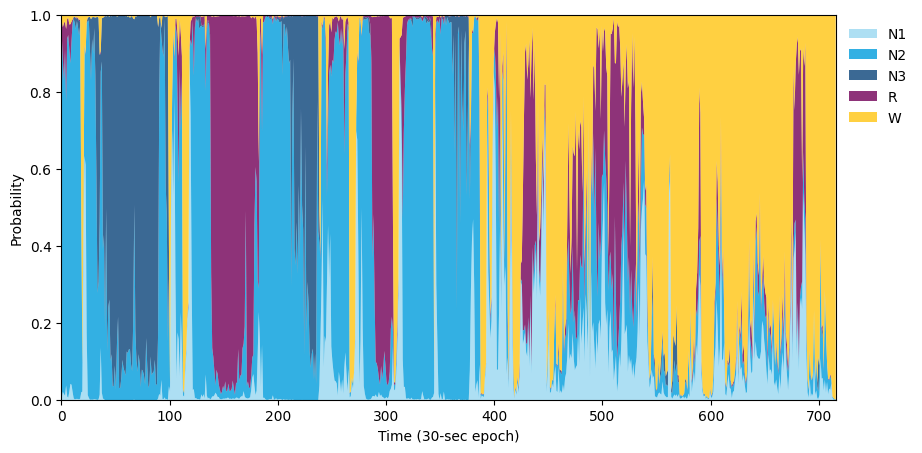

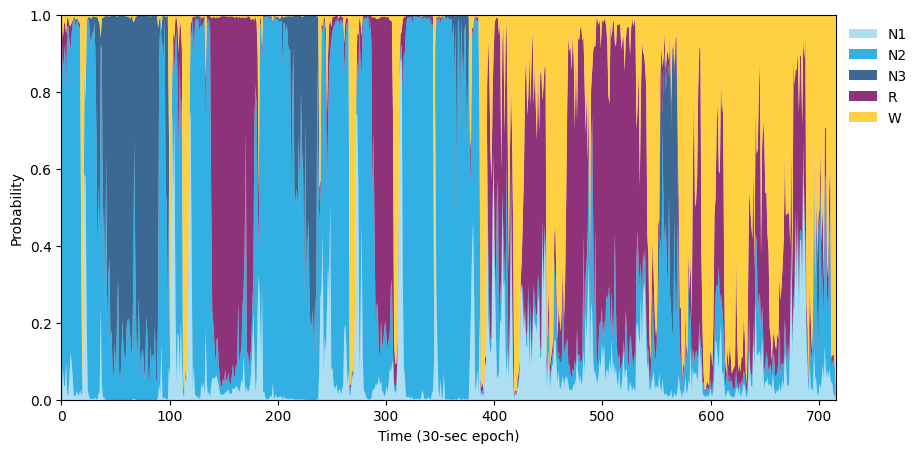

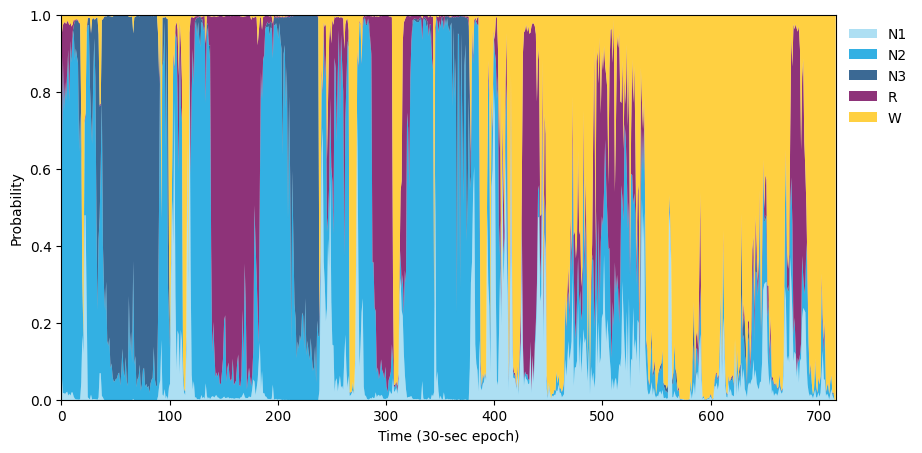

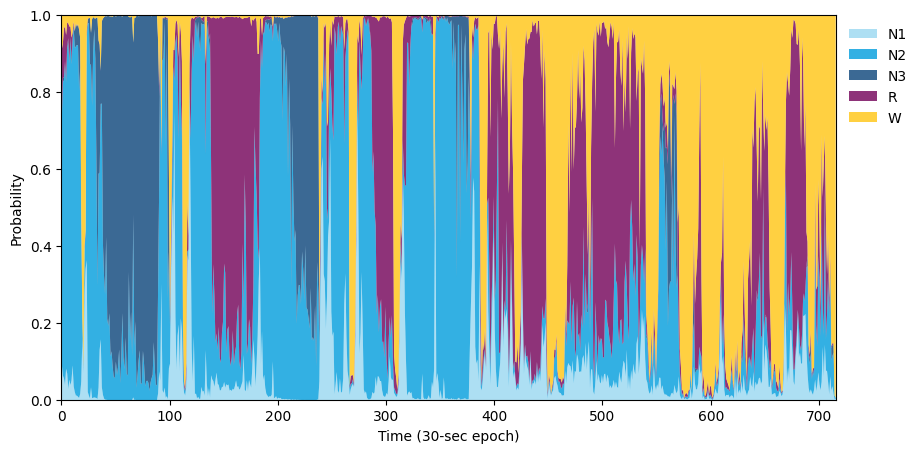

In [30]:
# We first need to specify the channel names and, optionally, the age and sex of the participant
# - "raw" is the name of the variable containing the polysomnography data loaded with MNE.
# - "eeg_name" is the name of the EEG channel, preferentially a central derivation (e.g. C4-M1). This is always required to run the sleep staging algorithm.
# - "eog_name" is the name of the EOG channel (e.g. LOC-M1). This is optional.
# - "emg_name" is the name of the EMG channel (e.g. EMG1-EMG3). This is optional.
# - "metadata" is a dictionary containing the age and sex of the participant. This is optional.
# Available channels: 'EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1', 'EEG A1-A2', 'EMG Chin', 'EMG Aux1'
male = xml_dict['Patient']['Gender'] == "Male"
age = xml_dict['Patient']['BirthDate']

sls_dfs = []
for eeg in ['EEG C3-A2', 'EEG C4-A1']:
    for emg in ['EMG Chin', 'EMG Aux1']:
        sls_i = yasa.SleepStaging(raw, eeg_name=eeg, emg_name=emg)#, metadata=dict(male=male, age = age)
        sls_dfs.append(sls_i.predict_proba())
        sls_i.plot_predict_proba()

# Compute the average prediction from this combination of central EEGs and available EMGs
sls_df = (sls_dfs[0] + sls_dfs[1] + sls_dfs[2] + sls_dfs[3]) / 4
# Store the predicted annotations
y_pred = sls_df.idxmax(axis=1).values

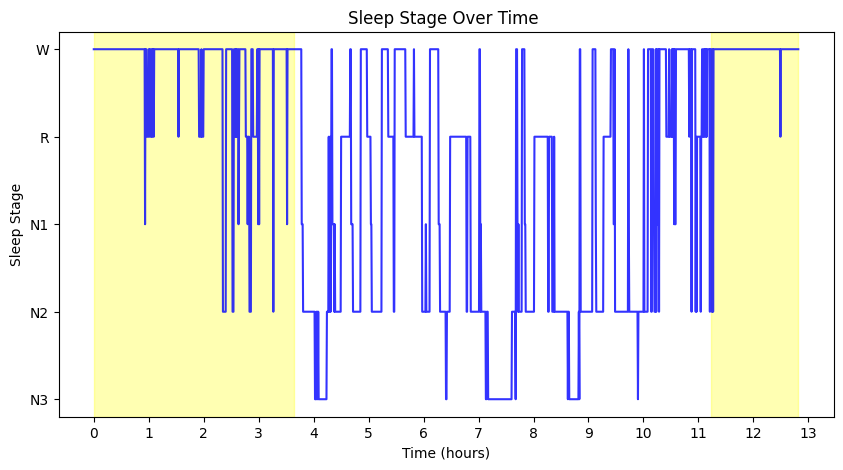

In [10]:
def stage_plotter(y_pred, t_lightOFF = None, t_lightON = None, invert = False, title_extra=""):
   # Mapping of stages to numeric values
    stage_mapping = {'N3': 0, 'N2': 1, 'N1': 2, 'R': 3, 'W': 4}
    
    # Convert the stages to numeric values using the mapping
    y_mapped = np.array([stage_mapping[stage] for stage in y_pred])
    
    # Create an x-axis array: each point is 30 seconds after the previous
    x_axis = np.arange(len(y_pred)) * 30 / 3600  # Convert seconds to hours
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, y_mapped,linestyle='-', color='b', alpha=0.8)
    
    # Add yellow background for specified time periods
    if t_lightOFF is not None:
        plt.axvspan(0, t_lightOFF / 3660, color='yellow', alpha=0.3)  # Before light off
    if t_lightON is not None:
        plt.axvspan(t_lightON / 3660, x_axis[-1], color='yellow', alpha=0.3)  # After light on
    
    # Customizing the axes
    plt.xlabel('Time (hours)')
    plt.ylabel('Sleep Stage')
    plt.xticks(np.arange(0, x_axis[-1] + 1, 1))  # Display only whole number hours
    plt.yticks(np.arange(len(stage_mapping)), list(stage_mapping.keys()))  # Set y-ticks as stage names
    
    # Invert y-axis if specified
    if invert:
        plt.gca().invert_yaxis()  # Invert y-axis to display 'N3' at the top
    
    plt.title('Sleep Stage Over Time ' + title_extra)
    plt.show()


stage_plotter(y_pred, int(t_lightOFF), int(t_lightON))

#### Section 2.3: Time Point Subsetting
After Confirming a file is worth evaluating, the start time point should be used to discard pre-sleep recording data. The MNE interval function can then be used to extract and seperateley evaluate the first, second, third, and fourth hour of sleep for the patient.

Note on units, y_pred is an array of sleep stage predictions every 30 seconds

raw is at this stage a 100 Hz recording, thus dividing it by 3000 will make it the same lenght as y_pred, whereas dividing by 6000 will convert it into observations per minute

t_lights_off is a time point in seconds when the lights are turned off after the recording started

Thus the first step is to use t_lightsOFF to trim the begining of both y_pred and raw, followed by further trimming of y_pred and raw to the first N1 observation time point to indicate the initiation of sleep

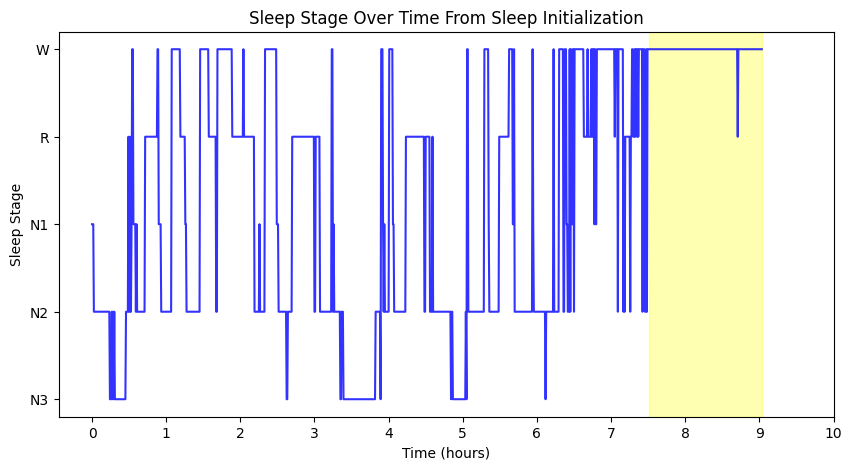

In [11]:
t_0 = int(t_lightOFF) # the time point is in seconds after onset of recording

# Calculate how many intervals to crop from y_pred based on t_0
# Each interval represents 30 seconds, so t_0 in seconds divided by 30 gives the number of intervals to crop
intervals_to_crop = int(t_0 / 30)
y_pred_sleep = y_pred[intervals_to_crop:]

# Find the index of the first instance of 'N1' in the newly trimmed y_pred
onset_ind = np.where(y_pred_sleep == 'N1')[0][0]
y_pred_sleep = y_pred_sleep[onset_ind:]

t_lightON2 = int(t_lightON) - t_0 - onset_ind*30
stage_plotter(y_pred_sleep, t_lightON = t_lightON2, title_extra="From Sleep Initialization")

In [13]:
# Convert t_0 from seconds to samples to avoid inconsistencies
sfreq = raw.info['sfreq']  # Sampling frequency
t_0 = int(t_0 * sfreq)

# Crop the MNE raw object to start from t_0
raw.crop(tmin=t_0 / sfreq)
# Use onset_ind to further crop raw and y_pred to start from the first moment of sleep
# Convert onset_ind back to seconds to use with raw.crop
onset_seconds = onset_ind * 30  # Each index represents 30 seconds
# Crop raw to start from the first moment of sleep (the onset of 'N1')
raw.crop(tmin=onset_seconds)

# Each hour contains 120 intervals of 30 seconds
intervals_per_hour = 3600 // 30

subset_dict = {}
for i in range(4):
    t_0 = i*3600
    t_1 = t_0 +3600
    raw_x_hour = raw.copy().crop(tmin=t_0, tmax=t_1)
    data_x_hour, times_x_hour = raw_x_hour[:, :]
    if i ==0:
        y_pred_x = y_pred_sleep[:intervals_per_hour]
    else:
        y_pred_x = y_pred_sleep[intervals_per_hour*i:intervals_per_hour*(i+1)]
    subset_dict[i] = {}
    subset_dict[i]["data all"] = data_x_hour
    subset_dict[i]["times all"] = times_x_hour
    subset_dict[i]["sls all"] = y_pred_x

#### Section 2.4: Removal of Wake Events
After subsetting the time points, the final data cleaning step is to discard all time points related to wake events

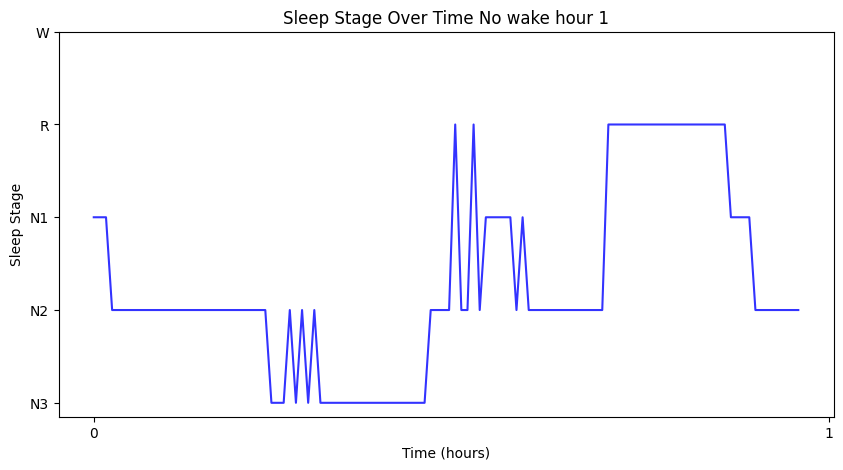

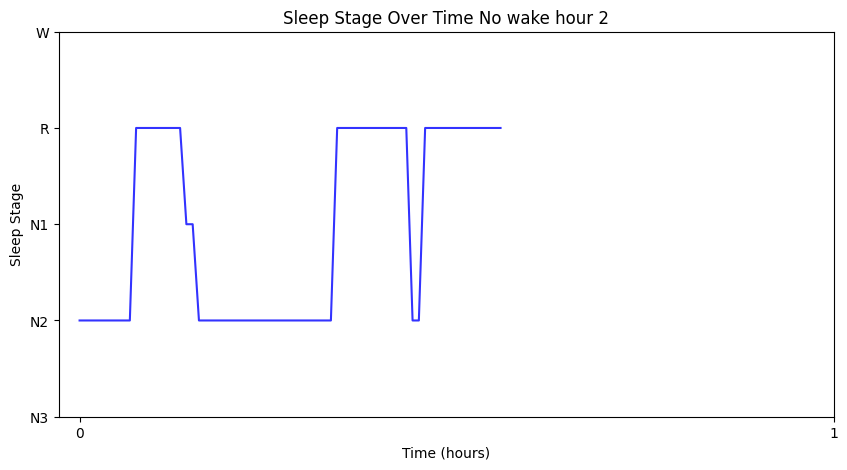

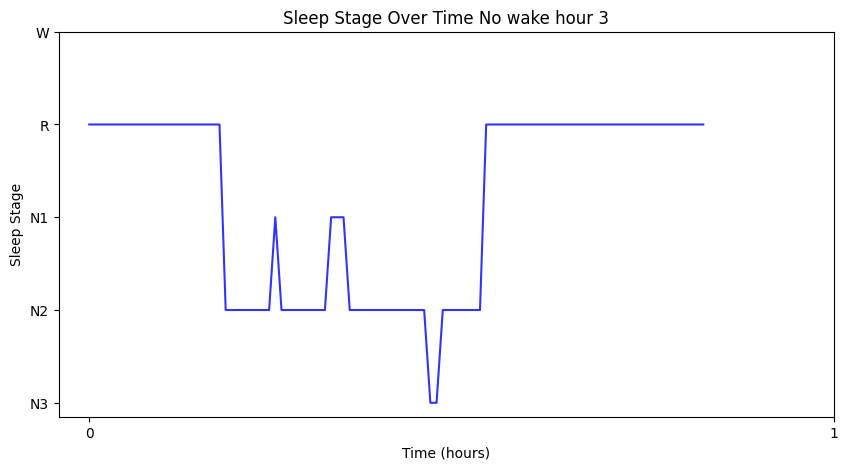

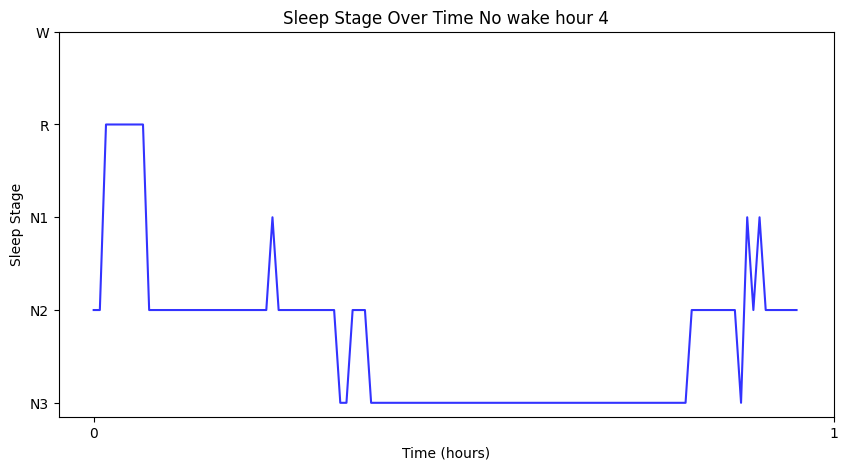

In [17]:
def filter_wake_stages(data, times, y_pred_segment, sfreq):
    """
    Remove data and time points corresponding to "W" stages in y_pred_segment.
    Additionally, returns the filtered y_pred_segment without "W" stages.
    
    Args:
    - data: The data array for the hour.
    - times: The times array for the hour.
    - y_pred_segment: The y_pred array segment for the hour.
    - sfreq: Sampling frequency.
    
    Returns:
    - filtered_data: Data array after removing "W" stages.
    - filtered_times: Times array after removing "W" stages.
    - filtered_y_pred_segment: y_pred_segment array after removing "W" stages.
    """
    # Find indices where y_pred_segment is not "W"
    not_w_indices = np.where(y_pred_segment != 'W')[0]
    
    # Number of samples per 30-second segment
    samples_per_segment = int(30 * sfreq)
    
    # Filter the data and times based on not "W" indices
    filtered_data = np.concatenate([data[:, i*samples_per_segment:(i+1)*samples_per_segment] for i in not_w_indices], axis=1)
    filtered_times = np.concatenate([times[i*samples_per_segment:(i+1)*samples_per_segment] for i in not_w_indices])
    filtered_y_pred_segment = y_pred_segment[not_w_indices]
    
    return filtered_data, filtered_times, filtered_y_pred_segment


for i in range(4):
    subset_dict[i]["data"] , subset_dict[i]["times"], subset_dict[i]["sls"] = filter_wake_stages(subset_dict[i]["data all"] , 
                                                                                                 subset_dict[i]["times all"], 
                                                                                                 subset_dict[i]["sls all"], sfreq)
    stage_plotter(subset_dict[i]["sls"], title_extra=f"No wake hour {i+1}")

### Section 3: Computing Multitaper Spectra
Computing and ploting of the multitaper spectral estimation method as previously used by Negar for all time points can be performed as demonstrated in the next cell. 
More info on Multitapers can be found here: https://ieeexplore.ieee.org/document/6767046

In [18]:
# Hyperparameters:
fmin = 0.1
fmax = 40

# Compute PSD for the each hour
for i in range(4):
    subset_dict[i]["PSD"] , subset_dict[i]["PSD Freqs"],=  mne.time_frequency.psd_array_multitaper(subset_dict[i]["data"],
                                                                 sfreq=sfreq, fmin=fmin, fmax=fmax, adaptive=False, 
                                                                 normalization='length', verbose=True)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


### Section 4: Data Visualization

Loaded channels can be easily visualized as demonstrated in these plots of the first and second hour of sleep forthe subset eeg channels. 
Documentation: https://mne.tools/dev/generated/mne.io.Raw.html#mne.io.Raw.plot (see 'plot')

In [22]:
.subset_dict[i]["data all"]

(7, 360001)

Using matplotlib as 2D backend.


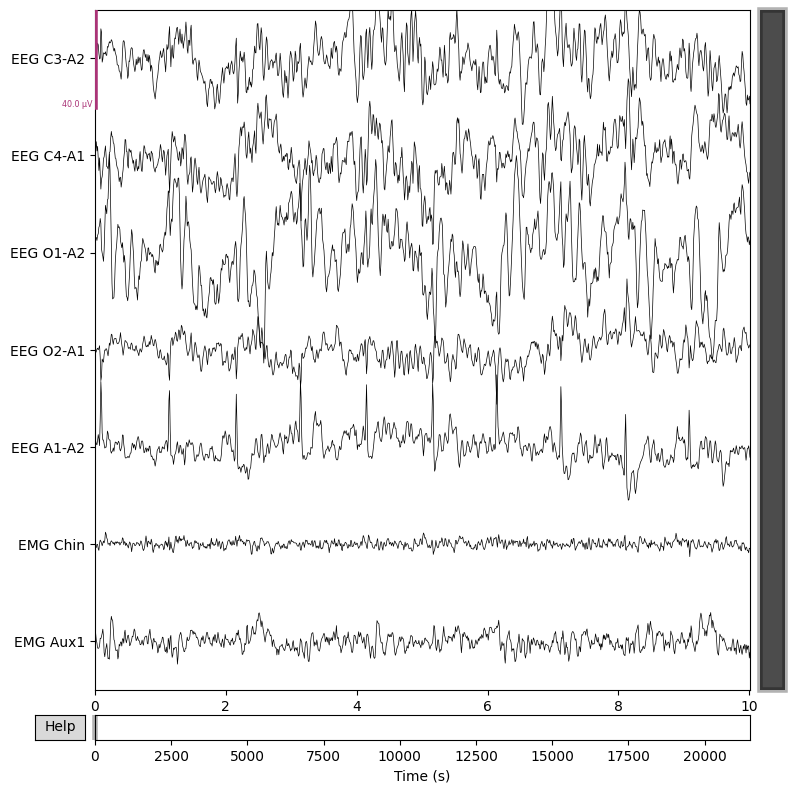

In [23]:
# Plot the EEG data for demonstration purposes
raw.plot(start=0, scalings=None, title='First Hour: EEG Channels')

plt.show()
plt.close()

Output: 

To viaulize the results of the multitaper spectra one can now use matplotlib directly as demonstrated below.

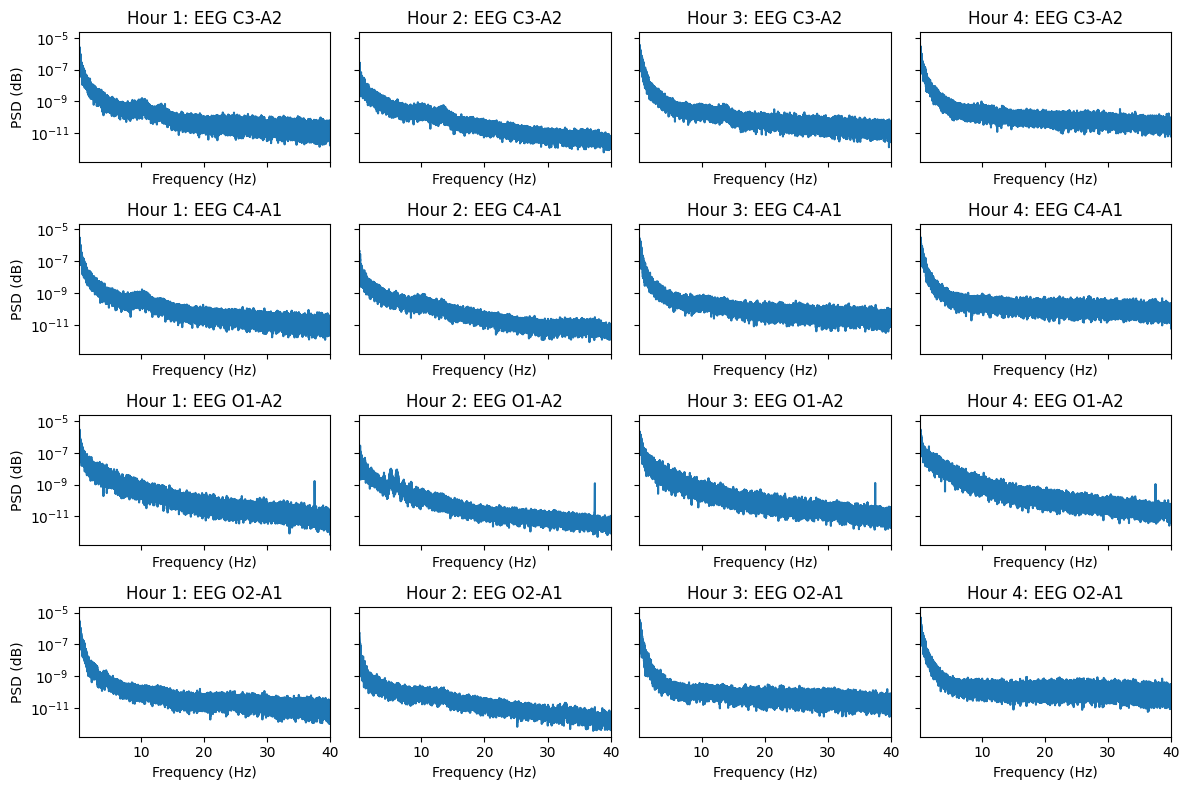

In [24]:
# Assume channels and subset_dict are defined, as well as sfreq, fmin, and fmax
channels = ['EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1']
n_channels = len(channels)
n_hours = len(subset_dict)  # Number of hours for which data is available

# Setup the figure and axes
fig, axes = plt.subplots(nrows=n_channels, ncols=n_hours, figsize=(12, 8), sharex=True, sharey=True)

# Iterate over each channel and each hour to plot
for i, channel in enumerate(channels):
    for j in range(n_hours):
        # Assuming the PSD and Frequencies are stored in the subset_dict for each hour
        psd = subset_dict[j]["PSD"][i]  # Accessing the PSD for the current channel
        freqs = subset_dict[j]["PSD Freqs"]  # Accessing the frequency values
        
        # Plotting
        axes[i, j].semilogy(freqs, psd.T, label=f'Hour {j+1}: {channel}')
        axes[i, j].set_xlabel('Frequency (Hz)')
        if j == 0:
            axes[i, j].set_ylabel('PSD (dB)')
        axes[i, j].set_title(f'Hour {j+1}: {channel}')
        axes[i, j].set_xlim([0.1, 40])

# Adjust layout
plt.tight_layout()
plt.show()


### Section 5: Normalization of Multitaper spectra

A simple and efficient method to normalize multiatper spectra power is to simply identify the maximum value observed for a given patient's EEG location during the recording session of interest, in this case the first and second hour of sleep. This maximum value can then simply be used to divide and thus normalize all observations for this channel such that the maximum value for all patients and all channesl is 1 and the minimum is zero. To do this a simple for loop was constructed as below. With the above visualization being recreated in matplotlib.

#### Advantages and Disadvantages of Max Normalization for EEG Sleep Data

**Advantages:**

Accounts for individual differences: By dividing the band power values by the maximum observed value for each patient, this normalization method helps account for variability in overall EEG power levels between individuals. This can be useful for comparing power spectra across different patients or groups. 

Scales data to a common 0-1 range: The max normalization places all the power spectra on a common 0 to 1 scale, which can facilitate comparisons across channels, patients, or conditions. 

Commonly used in the literature: See reviews indicating that this max normalization approach is a widely adopted technique for normalizing EEG power spectra, particularly in sleep studies. 

**Disadvantages:**

Potential loss of information: By scaling all values relative to the maximum, this normalization method may result in a loss of information about the absolute power levels in the EEG data. The relative differences between values are preserved, but the original magnitude information is discarded. 

Sensitivity to outliers: The normalization is dependent on identifying the maximum value, so it can be sensitive to the presence of outliers or artifacts in the data, which could skew the scaling. 

Multiple comparisons problem: As mentioned in the Prerau et al. review, the large number of potential outcome measures that can be derived from EEG data (e.g. by channel, frequency band, sleep stage) increases the risk of false positive findings due to the multiple comparisons problem. Careful statistical correction is required. 

References 

https://www.diva-portal.org/smash/get/diva2:1688615/FULLTEXT01.pdf

https://prerau.bwh.harvard.edu/seminar_papers/Cox_EEG_methods_primer.pdf

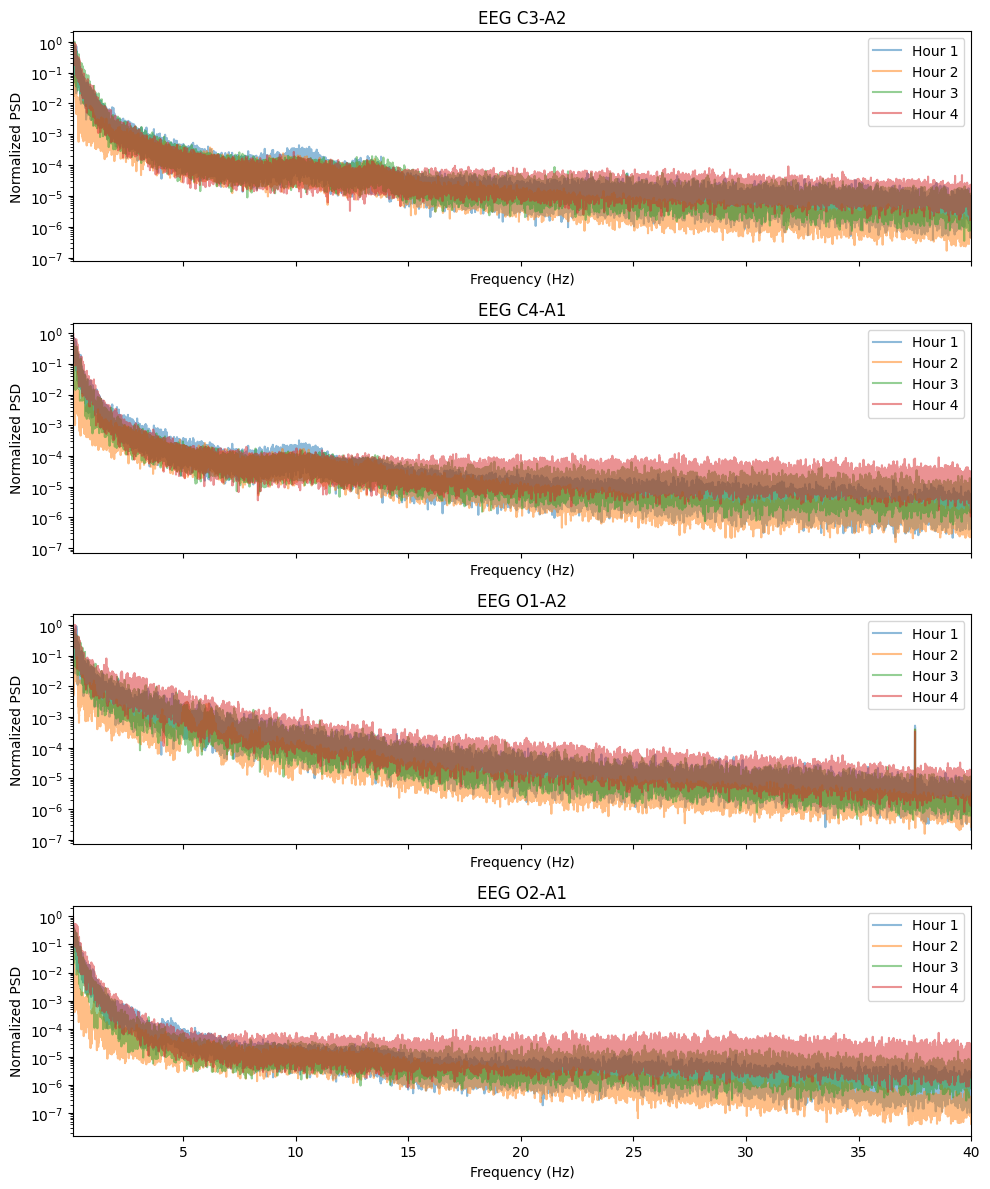

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'subset_dict' is your data source and 'channels' is defined
n_hours = len(subset_dict)
n_channels = len(channels)

# Preinitialize zero vectors for normalized PSDs for all hours
normalized_psds = [np.zeros_like(subset_dict[hour]["PSD"]) for hour in range(n_hours)]

# Normalize the PSDs across all hours for each channel
for i in range(n_channels):  # Iterate over each channel
    # Find the maximum PSD value for the current channel across all hours
    max_value = max(np.max(subset_dict[hour]["PSD"][i]) for hour in range(n_hours))
    
    # Normalize the PSD values by the maximum value for each hour
    for hour in range(n_hours):
        normalized_psds[hour][i] = subset_dict[hour]["PSD"][i] / max_value

# Setup the figure and axes for n_channels rows and 1 column
fig, axes = plt.subplots(nrows=n_channels, ncols=1, figsize=(10, 12), sharex='all', sharey='row')
if n_channels == 1:
    axes = [axes]  # Make sure axes is iterable for a single channel case

for i, channel in enumerate(channels):
    # Plot the normalized PSD for each hour, overlaying them
    for hour in range(n_hours):
        freqs = subset_dict[hour]["PSD Freqs"]
        axes[i].semilogy(freqs, normalized_psds[hour][i].T, label=f'Hour {hour+1}', alpha=0.5)
    
    # Set plot attributes
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Normalized PSD')
    axes[i].set_title(channel)
    axes[i].set_xlim([0.1, 40])
    axes[i].legend()

plt.tight_layout()
plt.show()


### Section 6: Headless Implementation

The following function performs all of the above steps in a single function call for efficient and automated extraction of the Multitaper spectra for a given patient. The example prints the output spectra but this is optional and by default disabled.

Extracting EDF parameters from /home/sam/Classes/Stats/Consulting/EEG_Consulting/Examples2024/00000016-APDx20974/00000016-APDx20974[001].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9235599  =      0.000 ... 46177.995 secs...


/tmp/ipykernel_1503217/864415505.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'Flow Patient'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(data_path, preload=True) # data path is the file's location


Channel Fail Events:

Other Comments:
  - possible premayure beat
  - possible premature beat
  - premature beats
  - quadrigeminy
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


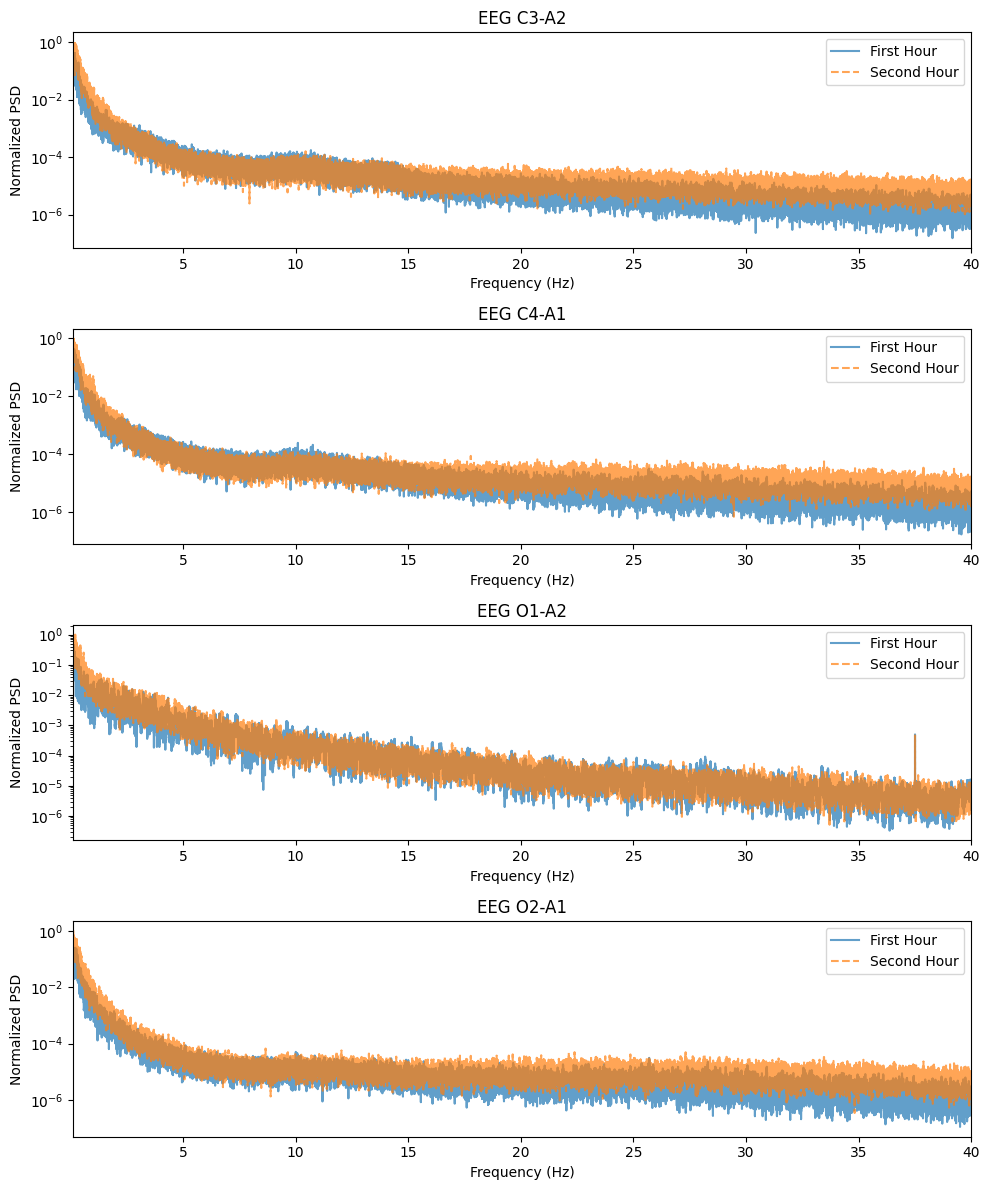

In [12]:
def EEG2Power(data_path, meta_path, 
              channels = ['EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1'], 
              fmin = 0.1, fmax = 40, visualize = False):
    # Load the EDF file
    raw = mne.io.read_raw_edf(data_path, preload=True) # data path is the file's location
    # Load the xml meta data
    xml_dict = convert_rml_to_dict(meta_path)
    # Extract Lights off time
    t_lightOFF = xml_dict['Acquisition']['Sessions']['Session']['LightsOff']
    # Extract commentary in the metadata
    scoring_data = xml_dict.get('ScoringData', {})
    channel_fail_events, other_comments = extract_relevant_annotations(scoring_data)
    # Display the warnings
    print("Channel Fail Events:")
    for event in channel_fail_events:
        print(f"  - {event}")
    print("\nOther Comments:")
    for comment in other_comments:
        print(f"  - {comment}")


    # Predict sleep stage
    sls_dfs = []
    for eeg in ['EEG C3-A2', 'EEG C4-A1']:
        for emg in ['EMG Chin', 'EMG Aux1']:
            sls_i = yasa.SleepStaging(raw, eeg_name=eeg, emg_name=emg)#, metadata=dict(male=male, age = age)
            sls_dfs.append(sls_i.predict_proba())
            if visualize:
                sls_i.plot_predict_proba()

    # Compute the average prediction from this combination of central EEGs and available EMGs
    sls_df = (sls_dfs[0] + sls_dfs[1] + sls_dfs[2] + sls_dfs[3]) / 4
    # Store the predicted annotations
    y_pred = sls_df.idxmax(axis=1).values
    
    # Subset to only EEG Channels and print general data
    selected_channels = raw.pick(channels)
    
    # Starting time must be established by medical expert, for demonstration purposes lights off time is used
    t_0 = int(t_lightOFF) # assume the time point is in seconds after onset of recording
    # Convert t_0 from seconds to samples to avoid inconsistencies
    sfreq = raw.info['sfreq']  # Sampling frequency
    t_0 = int(t_0 * sfreq)
    
    # Discard data before sleep onset
    raw.crop(tmin=t_0 / sfreq) # Note that we divide by sfreq again because raw.crop expects tmin and tmax in seconds, not samples.
    
    # Segment 1: First hour (0 to 3600 seconds)
    start_first_hour = 0  # Start immediately (assuming t_lightOFF adjustment is already made)
    end_first_hour = 3600  # End of first hour in seconds
    raw_first_hour = raw.copy().crop(tmin=start_first_hour, tmax=end_first_hour)
    data_first_hour, times_first_hour = raw_first_hour[:, :]
    
    # Segment 2: Second hour (3600 to 7200 seconds)
    start_second_hour = 3600  # Start of second hour in seconds
    end_second_hour = 7200  # End of second hour in seconds
    raw_second_hour = raw.copy().crop(tmin=start_second_hour, tmax=end_second_hour)
    data_second_hour, times_second_hour = raw_second_hour[:, :]
    
    
    # Compute PSD for the first hour
    psds_first_hour, freqs = mne.time_frequency.psd_array_multitaper(data_first_hour, sfreq=sfreq, fmin=fmin, fmax=fmax, adaptive=False, 
                                                                     normalization='length', verbose=True)
    
    # Compute PSD for the second hour
    psds_second_hour, freqs = mne.time_frequency.psd_array_multitaper(data_second_hour, sfreq=sfreq, fmin=fmin, fmax=fmax, adaptive=False, 
                                                                      normalization='length', verbose=True)

    # Each array has a shape of (n_channels, n_freqs), for memory management zero vectors are preinitialized
    normalized_psds_first_hour = np.zeros_like(psds_first_hour)
    normalized_psds_second_hour = np.zeros_like(psds_second_hour)
    
    for i in range(len(channels)):  # Iterate over each channel
        # Find the maximum PSD value for the current channel across both hours
        max_value = max(np.max(psds_first_hour[i]), np.max(psds_second_hour[i]))
        
        # Normalize the PSD values by the maximum value
        normalized_psds_first_hour[i] = psds_first_hour[i] / max_value
        normalized_psds_second_hour[i] = psds_second_hour[i] / max_value
    
        
    if visualize:
        # Setup the figure and axes for 4 rows (channels) and 1 column
        fig, axes = plt.subplots(nrows=len(channels), ncols=1, figsize=(10, 12))  # Adjust figsize as needed

        for i, channel in enumerate(channels):
            # Plot the normalized PSD for the first hour with alpha adjustment
            axes[i].semilogy(freqs, normalized_psds_first_hour[i].T, label='First Hour', alpha=0.7)
            
            # Plot the normalized PSD for the second hour with alpha adjustment
            axes[i].semilogy(freqs, normalized_psds_second_hour[i].T, label='Second Hour', linestyle='--', alpha=0.7)
            
            # Set plot attributes
            axes[i].set_xlabel('Frequency (Hz)')
            axes[i].set_ylabel('Normalized PSD')
            axes[i].set_title(channel)
            axes[i].set_xlim([0.1, 40])
            axes[i].legend()
        
        plt.tight_layout()
        plt.show()
        plt.close()
    
    return {"Freqs" : freqs,
           "Hour 1" : normalized_psds_first_hour,
           "Hour 2" : normalized_psds_second_hour}

# Example Useage
Normalized_dict = EEG2Power(data_path, meta_path, 
                              channels = ['EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1'], 
                              fmin = 0.1, fmax = 40, visualize = True)

### Section 7: Group Analysis
The final section of this workflow extracts investigator derived experiemtnal notes for crawling through the experiemtnal data, performing the above computations, and then assiging the power spectra to the correct experimental groups.

#### Section 6.1: Dataframe Iteration
This first function allows us to iterate through a dataframe and return the values in a specified column. In most cases, we use this to return a list of IDs associated with participants. 

In [13]:
def iterframe(frame, col):
    temp = []
    for item in frame[col]:
        temp.append(item)
    print(temp)
    return temp

Example implementation: 

In [14]:
df

NameError: name 'df' is not defined

In [ ]:
IDs = iterframe(df, 'ID')

#### Section 7.2: Dataframe Filtration
The next function is used to filter the dataset based on a specified value in a specified column. It returns a new dataframe that only contains rows that have the desired value. A function like this could be used to filter the dataset based on smoking/non-smoking status. 

In [ ]:
def extract_rows(frame, col, val):
    temp = frame[frame[col] == val]
    return temp

Example implementation: 

In [ ]:
new_df = extract_rows(df, 'Subject\'s sex at birth', 'M')

In [ ]:
new_df

#### Section 7.3: Median Computation

To be completed: We will take the median of a subset of the data so we can plot the median power at each frequency for comparison. 

Notes: 

We are missing a few functions because we had to show Dr. Kinney what we had done so far and get input based on how we were approaching the problem before we had everything we need. 

There is also potential that we need to implement another function that can filter out unwanted time segments in the data. Unwanted time segments could include times when the participant woke up during the night, for example. We are waiting to hear if these times have been removed from the data or not, and will proceed based on the response. 